Crowdstrike (ARCH / GARCH)

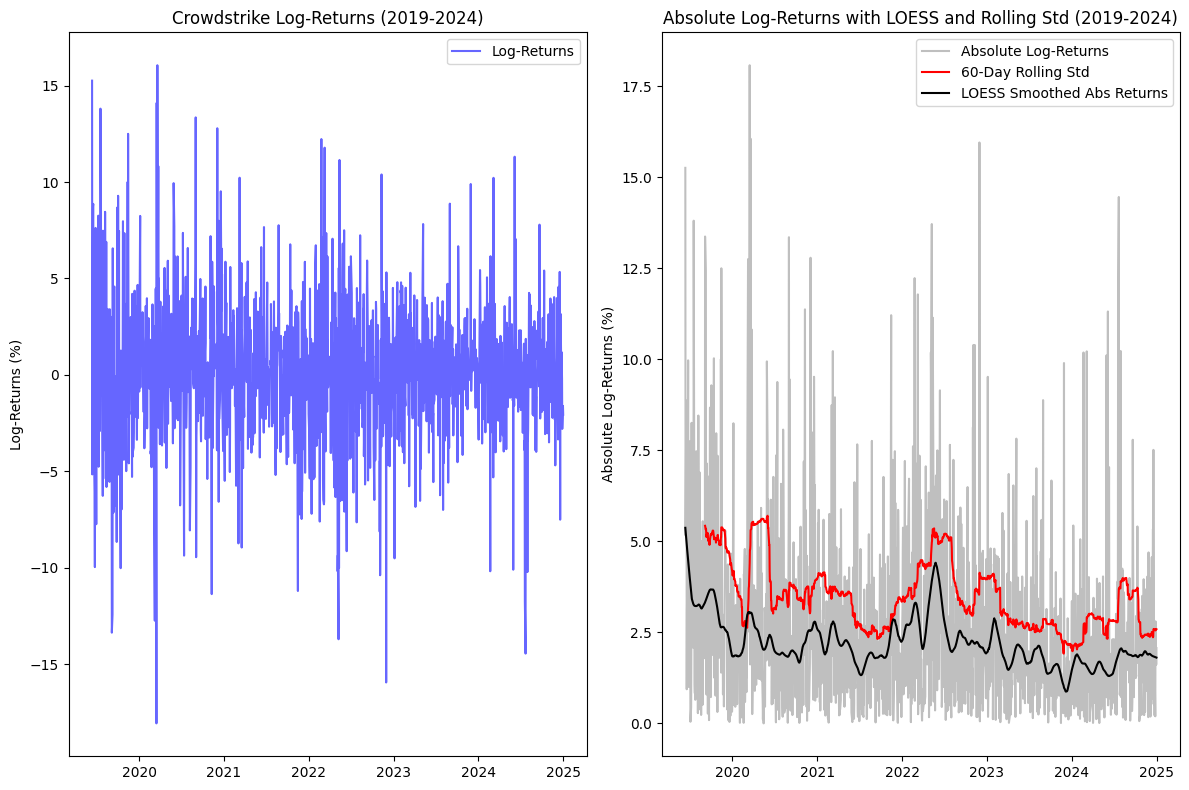

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Fetch Bitcoin data from Yahoo Finance (2019-2024)
btc = yf.download("CRWD", start="2019-01-01", end="2025-01-01", progress=False)

# Compute percentage log-returns
btc['Log_Return'] = np.log(btc['Close'] / btc['Close'].shift(1)) * 100
btc.dropna(inplace=True)

# Compute absolute log-returns
btc['Abs_Log_Return'] = np.abs(btc['Log_Return'])

# Compute rolling 60-day standard deviation
btc['Rolling_Std'] = btc['Log_Return'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(btc['Abs_Log_Return'], btc.index, frac=0.03)  # frac=0.03 controls smoothness

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(btc.index, btc['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("Crowdstrike Log-Returns (2019-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(btc.index, btc['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(btc.index, btc['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(btc.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2019-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

Mean: 0.1270
Variance: 13.1953
Skewness: -0.1157
Kurtosis: 2.5120
Normality Test p-value: 0.0000 (Not Normal)


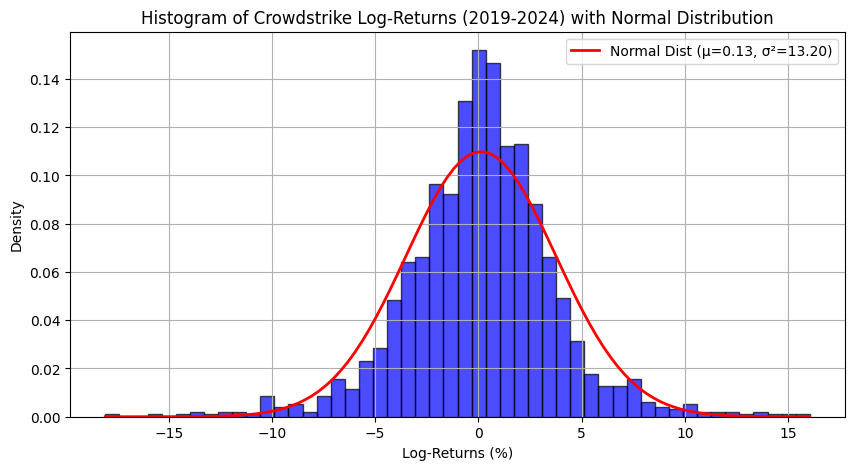

In [3]:
from scipy.stats import skew, kurtosis, normaltest, norm

# Compute statistics
mean_return = np.mean(btc['Log_Return'])
variance_return = np.var(btc['Log_Return'])
skewness_return = skew(btc['Log_Return'])
kurtosis_return = kurtosis(btc['Log_Return'])

# Normality test (D'Agostino and Pearson’s test)
stats_test, p_value = normaltest(btc['Log_Return'])
normality_result = "Normal" if p_value > 0.05 else "Not Normal"

# Print statistics
print(f"Mean: {mean_return:.4f}")
print(f"Variance: {variance_return:.4f}")
print(f"Skewness: {skewness_return:.4f}")
print(f"Kurtosis: {kurtosis_return:.4f}")
print(f"Normality Test p-value: {p_value:.4f} ({normality_result})")

# Plot histogram with overlaid normal distribution
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(btc['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal distribution curve
x = np.linspace(bins[0], bins[-1], 100)
pdf = norm.pdf(x, mean_return, np.sqrt(variance_return))
plt.plot(x, pdf, color='red', lw=2, label=f'Normal Dist (μ={mean_return:.2f}, σ²={variance_return:.2f})')

plt.xlabel("Log-Returns (%)")
plt.ylabel("Density")
plt.title("Histogram of Crowdstrike Log-Returns (2019-2024) with Normal Distribution")
plt.legend()
plt.grid()
plt.show()

Fitted t-distribution parameters:
Degrees of Freedom: 4.1233
Location: 0.1736
Scale: 2.6777
Variance: 13.9241
Kurtosis: 48.6545


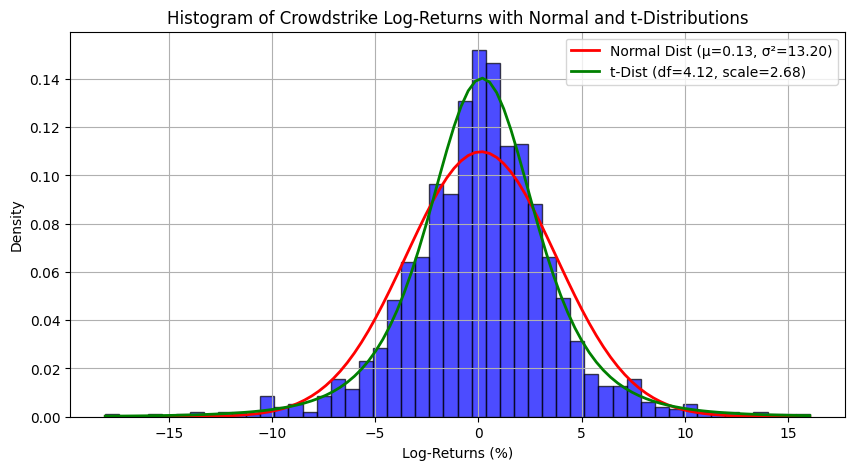

In [4]:
from scipy.stats import t

# Fit a t-distribution to the log-returns
params = t.fit(btc['Log_Return'])  # Direct fitting

# Extract fitted parameters
df_t, loc_t, scale_t = params

# Compute variance and kurtosis of the fitted t-distribution
variance_t = (df_t / (df_t - 2)) * (scale_t ** 2) if df_t > 2 else np.nan
kurtosis_t = (6 / (df_t - 4)) if df_t > 4 else np.inf  # Infinite for df <= 4

# Print fitted parameters and statistics
print(f"Fitted t-distribution parameters:")
print(f"Degrees of Freedom: {df_t:.4f}")
print(f"Location: {loc_t:.4f}")
print(f"Scale: {scale_t:.4f}")
print(f"Variance: {variance_t:.4f}")
print(f"Kurtosis: {'Infinite' if np.isinf(kurtosis_t) else f'{kurtosis_t:.4f}'}")

# Plot histogram with normal and t-distribution curves
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(btc['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal and t-distribution curves
x = np.linspace(bins[0], bins[-1], 100)
pdf_norm = norm.pdf(x, np.mean(btc['Log_Return']), np.std(btc['Log_Return']))
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

plt.plot(x, pdf_norm, color='red', lw=2, label=f'Normal Dist (μ={np.mean(btc["Log_Return"]):.2f}, σ²={np.var(btc["Log_Return"]):.2f})')
plt.plot(x, pdf_t, color='green', lw=2, label=f't-Dist (df={df_t:.2f}, scale={scale_t:.2f})')

plt.xlabel("Log-Returns (%)")
plt.ylabel("Density")
plt.title("Histogram of Crowdstrike Log-Returns with Normal and t-Distributions")
plt.legend()
plt.grid()
plt.show()


Model Summary:
                              AR - GARCH Model Results                              
Dep. Variable:                   Log_Return   R-squared:                       0.001
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -3662.62
Distribution:      Standardized Student's t   AIC:                           7337.24
Method:                  Maximum Likelihood   BIC:                           7368.69
                                              No. Observations:                 1397
Date:                      Thu, Mar 13 2025   Df Residuals:                     1395
Time:                              17:37:33   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------

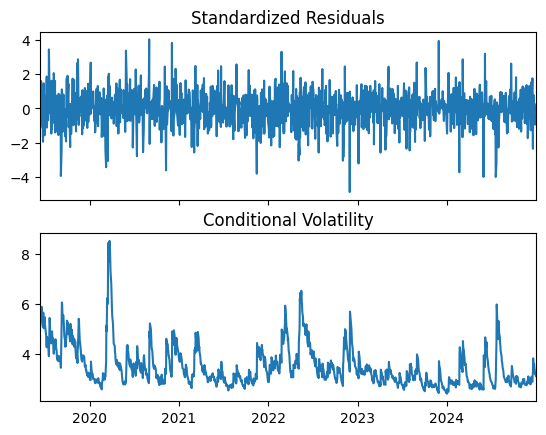

In [5]:
from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
returns = btc['Log_Return'].dropna()

# Fit GARCH(1,1) model with t-distributed errors
garch_model = arch_model(returns, mean = 'AR', lags= 1, vol='Garch', p=1, o=0, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')
print("\nModel Summary:")
print(garch_fit.summary())

# Plot GJR-GARCH model results
fig = garch_fit.plot()
plt.show()

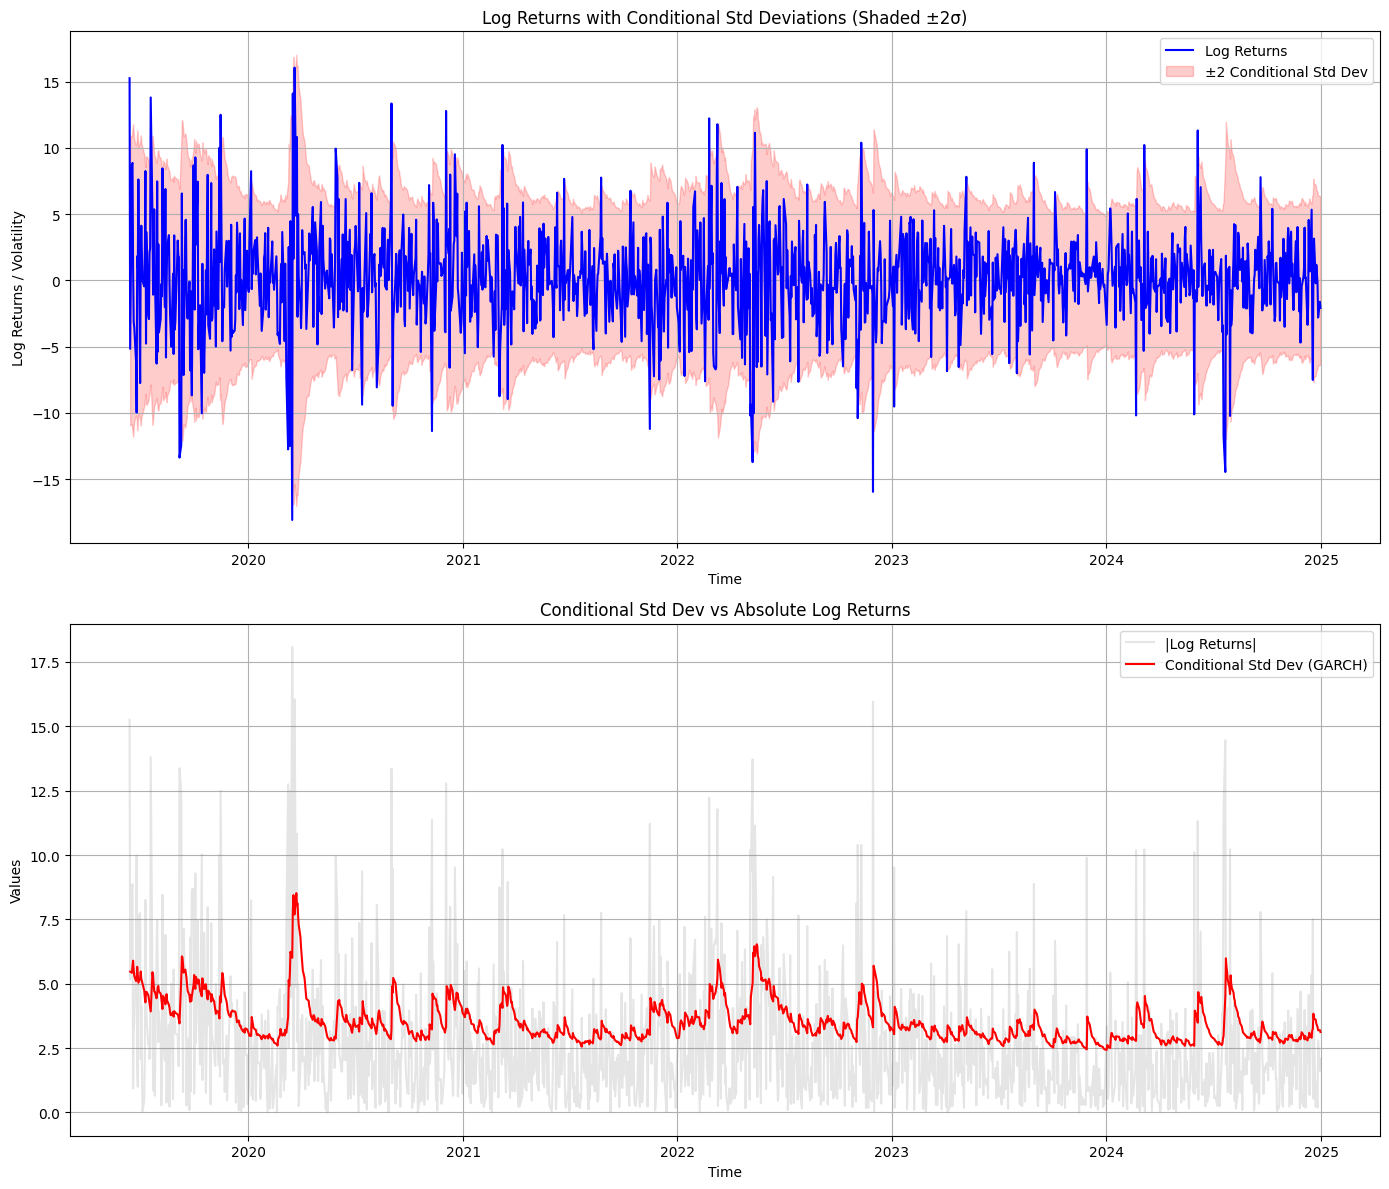

In [6]:
# Get the conditional volatility (sigma_t) and standardized residuals
conditional_volatility = garch_fit.conditional_volatility
absolute_log_returns = np.abs(returns)

# Combined plot with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Log returns with shaded ±2 conditional standard deviations
axs[0].plot(returns, label='Log Returns', color='blue')
upper_bound = 2 * conditional_volatility
lower_bound = -2 * conditional_volatility
axs[0].fill_between(btc.index, lower_bound, upper_bound, color='red', alpha=0.2, label='±2 Conditional Std Dev')
axs[0].set_title('Log Returns with Conditional Std Deviations (Shaded ±2σ)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Log Returns / Volatility')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Conditional Std Dev vs. Absolute Log Returns
axs[1].plot(absolute_log_returns, label='|Log Returns|', color='gray', alpha=0.2)
axs[1].plot(conditional_volatility, label='Conditional Std Dev (GARCH)', color='red')
axs[1].set_title('Conditional Std Dev vs Absolute Log Returns')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.show()

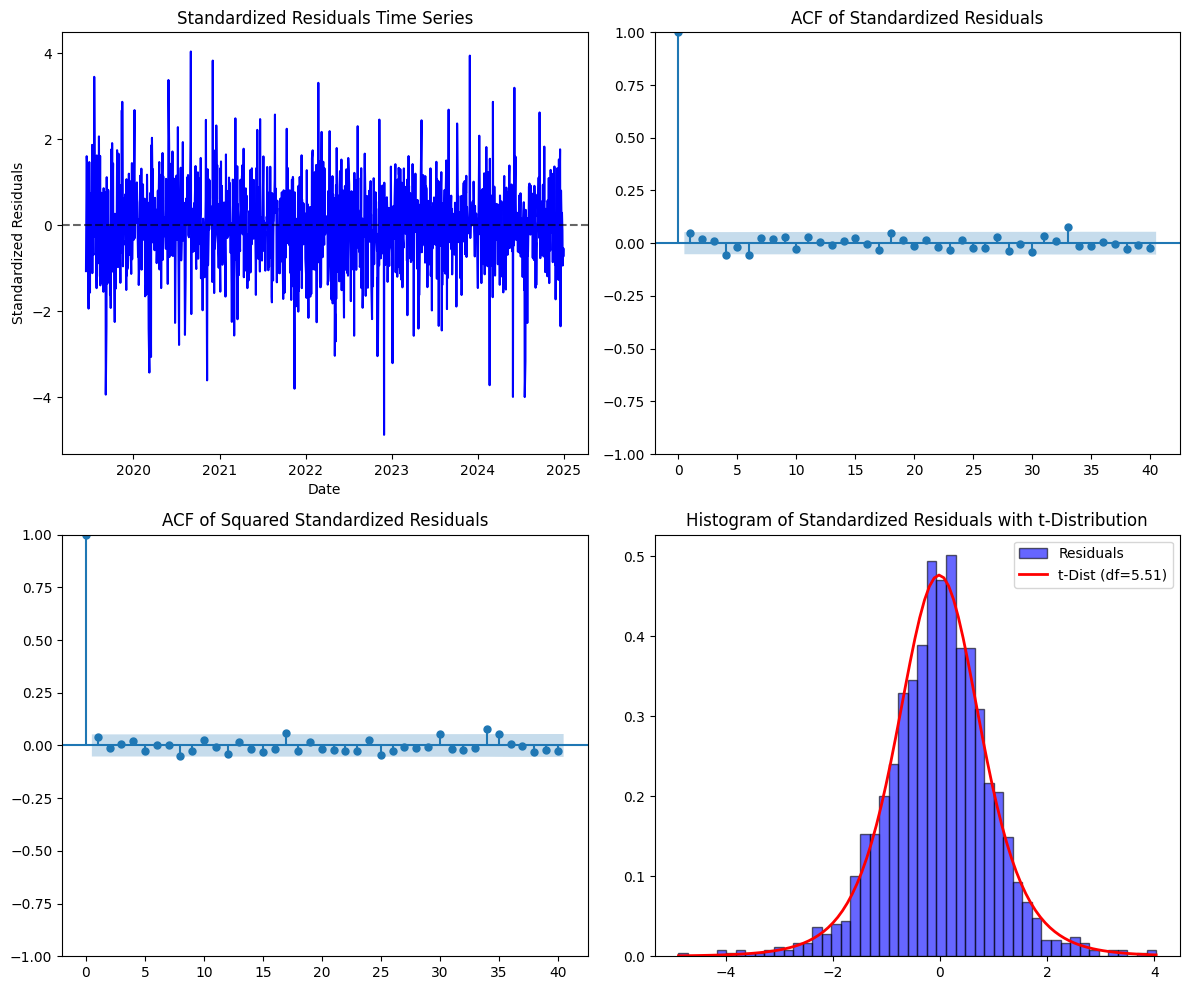

In [8]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, probplot

# Compute standardized residuals
std_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()

# Set up 2x2 residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Standardized residual time series
sns.lineplot(x=std_residuals.index, y=std_residuals, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Standardized Residuals Time Series")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.6)

# 2. ACF of standardized residuals
plot_acf(std_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title("ACF of Standardized Residuals")

# 3. ACF of squared standardized residuals
plot_acf(std_residuals**2, ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF of Squared Standardized Residuals")

# 4. QQ-plot with estimated t-distribution
df_t, loc_t, scale_t = t.fit(std_residuals)
x = np.linspace(min(std_residuals), max(std_residuals), 100)
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

axes[1, 1].hist(std_residuals, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black', label="Residuals")
axes[1, 1].plot(x, pdf_t, color='red', lw=2, label=f't-Dist (df={df_t:.2f})')
axes[1, 1].set_title("Histogram of Standardized Residuals with t-Distribution")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

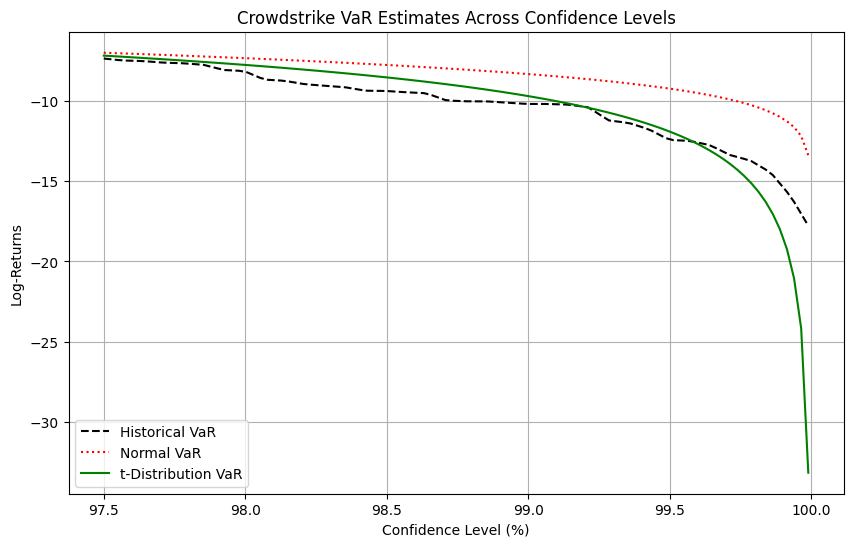

In [9]:
# Prepare the data
returns = btc['Log_Return'].dropna()

# Confidence levels for VaR
confidence_levels = np.linspace(0.975, 0.9999, 100)

# Compute VaR for different confidence levels
VaR_hist = [np.percentile(returns, (1 - alpha) * 100) for alpha in confidence_levels]
VaR_norm = [norm.ppf(1 - alpha, loc=np.mean(returns), scale=np.std(returns)) for alpha in confidence_levels]
df_t, loc_t, scale_t = t.fit(returns)
VaR_t = [loc_t + scale_t * t.ppf(1 - alpha, df_t) for alpha in confidence_levels]

# Plot VaR estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, VaR_hist, label='Historical VaR', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, VaR_norm, label='Normal VaR', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, VaR_t, label='t-Distribution VaR', linestyle='solid', color='green')

plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns")
plt.title("Crowdstrike VaR Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

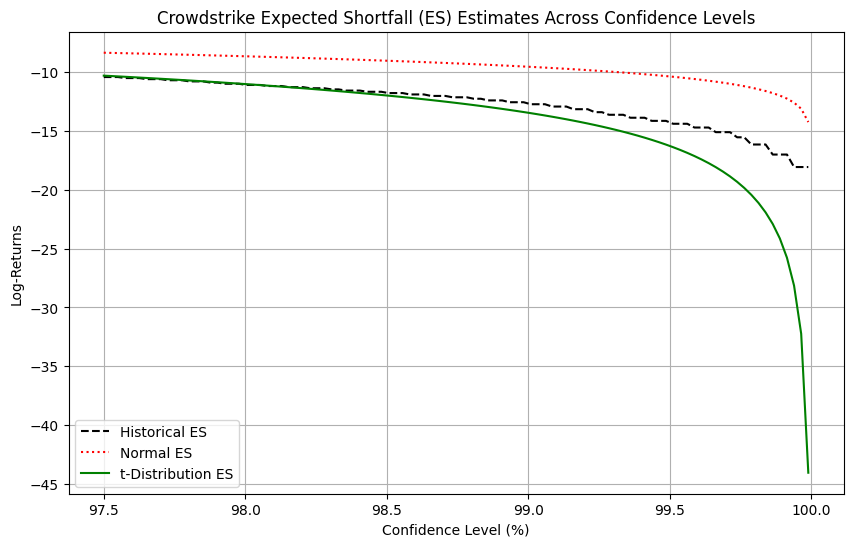

In [10]:
# Compute Expected Shortfall (ES) using the proper formulas
mean_return, std_return = returns.mean(), returns.std()
phi_norm = norm.pdf(norm.ppf(confidence_levels))
ES_norm = mean_return - std_return * (phi_norm / (1 - confidence_levels))

# Compute t-Distribution Expected Shortfall
t_alpha = t.ppf(confidence_levels, df_t)
t_pdf_alpha = t.pdf(t_alpha, df_t)
ES_t = loc_t - scale_t * (t_pdf_alpha / (1 - confidence_levels)) * (df_t + t_alpha**2) / (df_t - 1)

# Compute Historical Expected Shortfall (ES) directly from data
ES_hist = [returns[returns <= VaR_hist[i]].mean() for i in range(len(confidence_levels))]

# Plot Expected Shortfall (ES) estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, ES_hist, label='Historical ES', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, ES_norm, label='Normal ES', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, ES_t, label='t-Distribution ES', linestyle='solid', color='green')
plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns")
plt.title("Crowdstrike Expected Shortfall (ES) Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

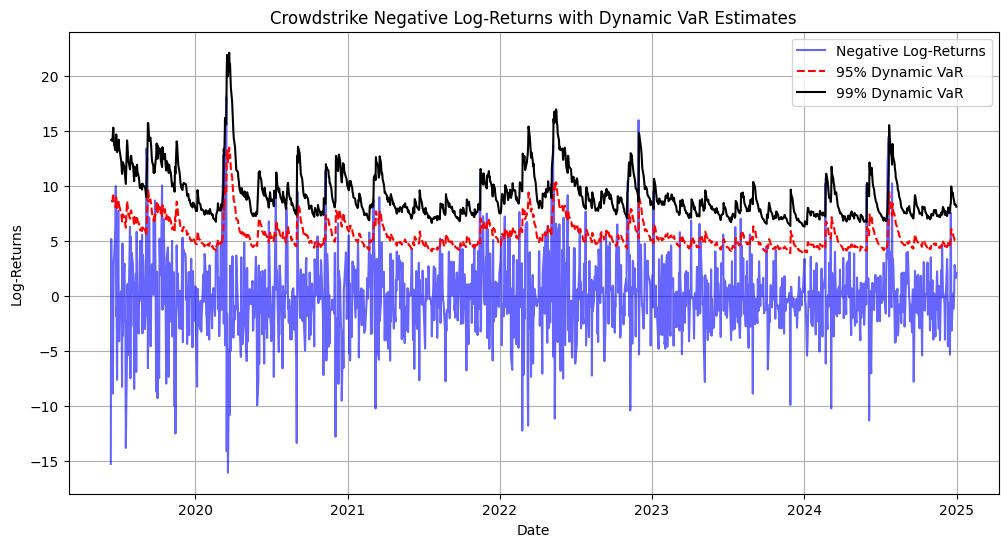

In [11]:
# Extract conditional volatility and standardized residuals
std_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()
cond_volatility = garch_fit.conditional_volatility.dropna()

# Fit t-distribution to standardized residuals
df_t, loc_t, scale_t = t.fit(std_residuals)

# Compute dynamic VaR at 95% and 99%
VaR_95 = -scale_t * t.ppf(0.05, df_t) * cond_volatility
VaR_99 = -scale_t * t.ppf(0.01, df_t) * cond_volatility

# Plot time series of negative log-returns with dynamic VaR
plt.figure(figsize=(12, 6))
plt.plot(-returns, label="Negative Log-Returns", color='blue', alpha=0.6)
plt.plot(VaR_95, label="95% Dynamic VaR", linestyle='dashed', color='red')
plt.plot(VaR_99, label="99% Dynamic VaR", linestyle='solid', color='black')

plt.xlabel("Date")
plt.ylabel("Log-Returns")
plt.title("Crowdstrike Negative Log-Returns with Dynamic VaR Estimates")
plt.legend()
plt.grid()
plt.show()